Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  It shares the same image size and structure of training and testing splits.

- ## Modify the code from HuskyCT to build MLP classifiers for the Fashion-MNIST dataset.
- ## Vary the number of neurons in the hidden layers and compare the accuracy results.
- ## Are the classification results better than the results we got in programming assignment #2?
- ## Use PCA to reduce the dimensionality of the dataset. Make sure we preserve 95% of the explained variance.
- ## Train a classifier using the dimensionality reduced dataset. Record the training time, compare the training time with the training time for the original dataset. Also compare the classification accuracy results.
- ## Do you observe anything surprising?
- ## Following and improve the example from the text to fine tune the neural network hyperparameters using RandomizedSearchCV. Note to use the dataset after the PCA step. This will make this search less time consuming.
- ## Report the test result using the best model obtained from the randomized search. Show the summary of the model. Compare this result with the previous result.

In [1]:
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
import mnist_reader
X_train, y_train = mnist_reader.load_mnist('', kind='train')
X_test, y_test = mnist_reader.load_mnist('', kind='t10k')

In [3]:
X_train.shape

(60000, 784)

In [4]:
y_train.shape

(60000,)

### Labels
Each training and test example is assigned to one of the following labels:

Label	Description
- 0	T-shirt/top
- 1	Trouser
- 2	Pullover
- 3	Dress
- 4	Coat
- 5	Sandal
- 6	Shirt
- 7	Sneaker
- 8	Bag
- 9	Ankle boot

In [5]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")

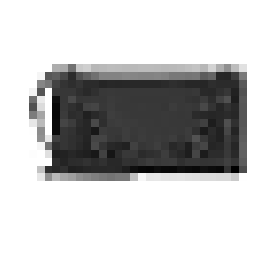

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X_train[36001]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off");

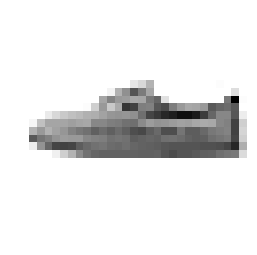

In [7]:
plot_digit(X_train[40000])

In [8]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

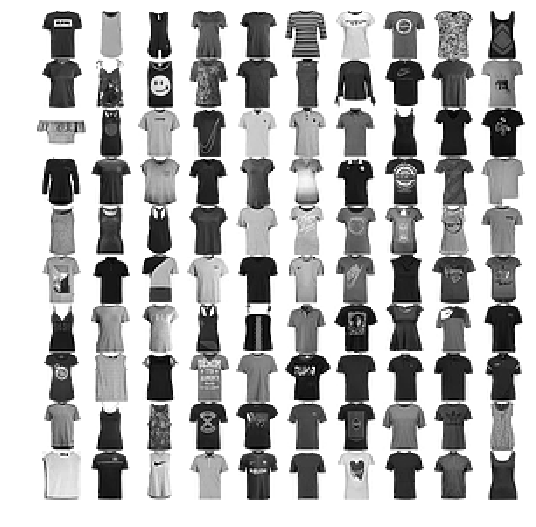

In [9]:
plt.figure(figsize=(9,9))
X_0 = X_train[(y_train == 0)]
example_images = X_0[:100]
plot_digits(example_images, images_per_row=10)

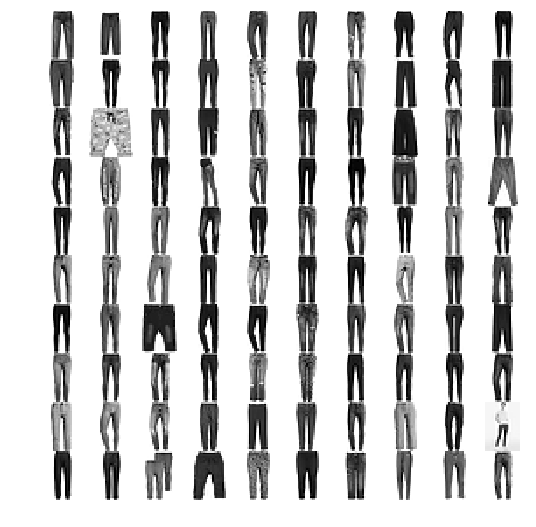

In [10]:
plt.figure(figsize=(9,9))
X_1 = X_train[(y_train == 1)]
example_images = X_1[:100]
plot_digits(example_images, images_per_row=10)

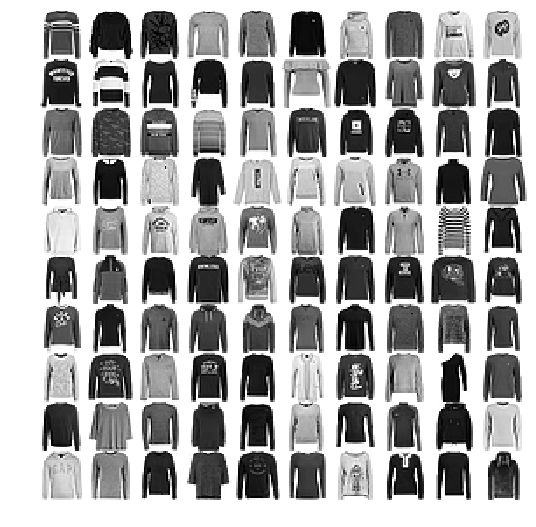

In [11]:
plt.figure(figsize=(9,9))
X_2 = X_train[(y_train == 2)]
example_images = X_2[:100]
plot_digits(example_images, images_per_row=10)

***Splitting validation set from training set, as it wasn't done for us***

Split loaded data for an additional validation set

In [12]:
# this block is used for keras.fashion_mnist becaues it's in color

X_val, X_train = X_train[:5000] / 255.0 , X_train[5000:] / 255.0
y_val, y_train = y_train[:5000], y_train[5000:]
X_test = X_test / 255.0

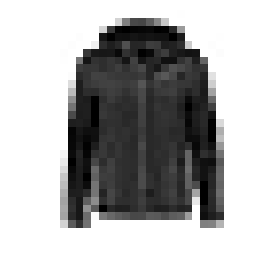

In [13]:
# take a look at the first article of clothes
plot_digit(X_train[0]) 

In [14]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Checking class names and the first item in the training set

In [15]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [16]:
class_names[y_train[0]]

'Coat'

Checking the training, validation, and test set size again

In [17]:
X_train.shape

(55000, 784)

In [18]:
X_train.dtype

dtype('float64')

In [19]:
X_val.shape

(5000, 784)

In [20]:
X_test.shape

(10000, 784)

We must reshape the data so that it usable down the line...

In [21]:
for i in X_train:
    i = i.reshape(28, 28)
    
X_train.shape

(55000, 784)

### 1. Training MLP Classifier from tf.keras

***Checking tensorflow installation***

In [22]:
import tensorflow as tf
from tensorflow import keras

tf.__version__

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'2.1.0'

In [23]:
keras.__version__

'2.2.4-tf'

***First Sequantial API***

In [24]:
# model = keras.models.Sequential()
# model.add(keras.layers.Flatten(input_shape=[784]))
# model.add(keras.layers.Dense(300, activation="relu"))
# model.add(keras.layers.Dense(100, activation="relu"))
# model.add(keras.layers.Dense(10, activation="softmax"))

In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[784]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.layers

In [29]:
# keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [30]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [31]:
model.get_layer('dense') is hidden1

True

In [32]:
weights, biases = hidden1.get_weights()

In [33]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [34]:
weights.shape

(784, 300)

In [35]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [36]:
biases.shape

(300,)

In [37]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer="sgd", 
              metrics=["accuracy"])

In [38]:
history = model.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 4s 67us/sample - loss: 0.7226 - accuracy: 0.7641 - val_loss: 0.5073 - val_accuracy: 0.8320
Epoch 2/30
55000/55000 [==============================] - 3s 58us/sample - loss: 0.4844 - accuracy: 0.8322 - val_loss: 0.4540 - val_accuracy: 0.8476
Epoch 3/30
55000/55000 [==============================] - 3s 56us/sample - loss: 0.4415 - accuracy: 0.8467 - val_loss: 0.4391 - val_accuracy: 0.8496
Epoch 4/30
55000/55000 [==============================] - 3s 56us/sample - loss: 0.4130 - accuracy: 0.8545 - val_loss: 0.4162 - val_accuracy: 0.8558
Epoch 5/30
55000/55000 [==============================] - 3s 56us/sample - loss: 0.3927 - accuracy: 0.8615 - val_loss: 0.3812 - val_accuracy: 0.8646
Epoch 6/30
55000/55000 [==============================] - 3s 56us/sample - loss: 0.3771 - accuracy: 0.8663 - val_loss: 0.3730 - val_accuracy: 0.8684
Epoch 7/30
55000/55000 [==============================] -

In [39]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [40]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

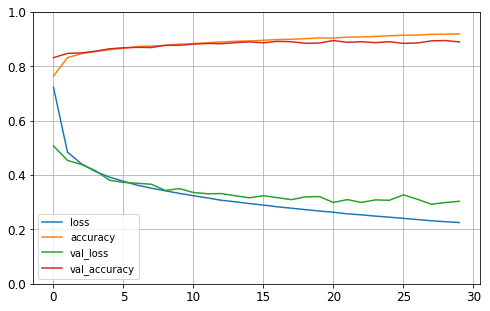

In [42]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

In [43]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 31us/sample - loss: 0.3364 - accuracy: 0.8792


[0.33641153327226636, 0.8792]

In [44]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [45]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1], dtype=int64)

In [46]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [47]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

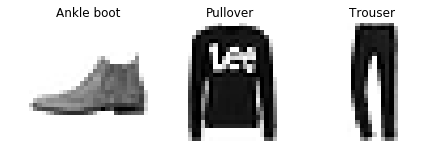

In [48]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    img_rs = image.reshape(28, 28)
    plt.subplot(1, 3, index + 1)
    plt.imshow(img_rs, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
# save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

***Tuning the amount of neurons and hidden layers to attempt to improve performance***

** Trial 2**

In [49]:
model2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[784]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [50]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 300)               235500    
_________________________________________________________________
dense_4 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_5 (Dense)              (None, 10)                510       
Total params: 251,060
Trainable params: 251,060
Non-trainable params: 0
_________________________________________________________________


In [51]:
model2.layers

In [52]:
model2.compile(loss="sparse_categorical_crossentropy", 
              optimizer="sgd", 
              metrics=["accuracy"])

In [53]:
history2 = model2.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 63us/sample - loss: 0.7182 - accuracy: 0.7628 - val_loss: 0.5110 - val_accuracy: 0.8198
Epoch 2/30
55000/55000 [==============================] - 3s 54us/sample - loss: 0.4909 - accuracy: 0.8269 - val_loss: 0.4679 - val_accuracy: 0.8388
Epoch 3/30
55000/55000 [==============================] - 3s 54us/sample - loss: 0.4490 - accuracy: 0.8416 - val_loss: 0.4351 - val_accuracy: 0.8534
Epoch 4/30
55000/55000 [==============================] - 3s 53us/sample - loss: 0.4208 - accuracy: 0.8513 - val_loss: 0.4228 - val_accuracy: 0.8538
Epoch 5/30
55000/55000 [==============================] - 3s 53us/sample - loss: 0.4008 - accuracy: 0.8588 - val_loss: 0.3889 - val_accuracy: 0.8656
Epoch 6/30
55000/55000 [==============================] - 3s 53us/sample - loss: 0.3856 - accuracy: 0.8650 - val_loss: 0.3873 - val_accuracy: 0.8660
Epoch 7/30
55000/55000 [==============================] -

In [54]:
history2.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

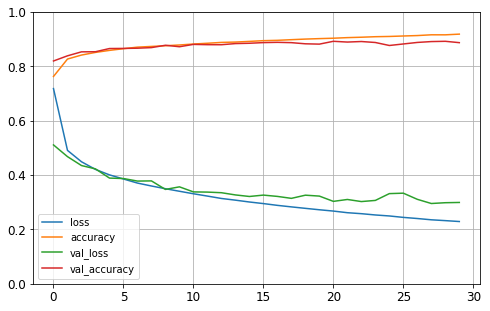

In [55]:
pd.DataFrame(history2.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

In [56]:
model2.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 32us/sample - loss: 0.3368 - accuracy: 0.8787


[0.33679274189472197, 0.8787]

** Trial 3**

In [57]:
model3 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[784]),
    keras.layers.Dense(40, activation="relu"),
    keras.layers.Dense(160, activation="relu"),
    keras.layers.Dense(50, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [58]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                31400     
_________________________________________________________________
dense_7 (Dense)              (None, 160)               6560      
_________________________________________________________________
dense_8 (Dense)              (None, 50)                8050      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
Total params: 46,520
Trainable params: 46,520
Non-trainable params: 0
_________________________________________________________________


In [59]:
model3.layers

In [60]:
model3.compile(loss="sparse_categorical_crossentropy", 
              optimizer="sgd", 
              metrics=["accuracy"])

In [61]:
history3 = model3.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 51us/sample - loss: 0.8666 - accuracy: 0.6963 - val_loss: 0.5702 - val_accuracy: 0.8044
Epoch 2/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.5309 - accuracy: 0.8121 - val_loss: 0.4901 - val_accuracy: 0.8294
Epoch 3/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.4783 - accuracy: 0.8296 - val_loss: 0.4375 - val_accuracy: 0.8504
Epoch 4/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.4440 - accuracy: 0.8418 - val_loss: 0.4293 - val_accuracy: 0.8522
Epoch 5/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.4208 - accuracy: 0.8505 - val_loss: 0.4017 - val_accuracy: 0.8564
Epoch 6/30
55000/55000 [==============================] - 2s 42us/sample - loss: 0.4044 - accuracy: 0.8557 - val_loss: 0.3907 - val_accuracy: 0.8632
Epoch 7/30
55000/55000 [==============================] -

In [62]:
history3.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

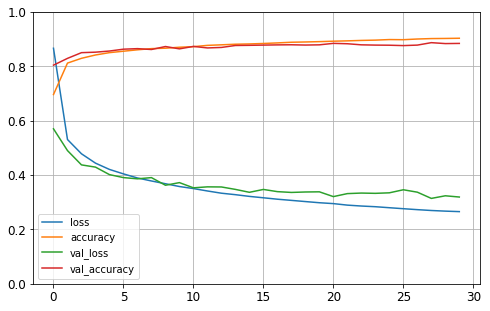

In [63]:
pd.DataFrame(history3.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

In [64]:
model3.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 26us/sample - loss: 0.3479 - accuracy: 0.8765


[0.34791599283218383, 0.8765]

**Trial 4**

In [65]:
model4 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[784]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [66]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_11 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_12 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1010      
Total params: 139,910
Trainable params: 139,910
Non-trainable params: 0
_________________________________________________________________


In [67]:
model4.layers

In [68]:
model4.compile(loss="sparse_categorical_crossentropy", 
              optimizer="sgd", 
              metrics=["accuracy"])

In [69]:
history4 = model4.fit(X_train, y_train, epochs=30, 
                    validation_data=(X_val, y_val))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 4s 66us/sample - loss: 0.7795 - accuracy: 0.7363 - val_loss: 0.5257 - val_accuracy: 0.8178
Epoch 2/30
55000/55000 [==============================] - 3s 57us/sample - loss: 0.5043 - accuracy: 0.8228 - val_loss: 0.4721 - val_accuracy: 0.8368
Epoch 3/30
55000/55000 [==============================] - 3s 57us/sample - loss: 0.4540 - accuracy: 0.8403 - val_loss: 0.4390 - val_accuracy: 0.8480
Epoch 4/30
55000/55000 [==============================] - 3s 57us/sample - loss: 0.4209 - accuracy: 0.8515 - val_loss: 0.4204 - val_accuracy: 0.8542
Epoch 5/30
55000/55000 [==============================] - 3s 57us/sample - loss: 0.3982 - accuracy: 0.8583 - val_loss: 0.3822 - val_accuracy: 0.8652
Epoch 6/30
55000/55000 [==============================] - 3s 57us/sample - loss: 0.3815 - accuracy: 0.8646 - val_loss: 0.3722 - val_accuracy: 0.8692
Epoch 7/30
55000/55000 [==============================] -

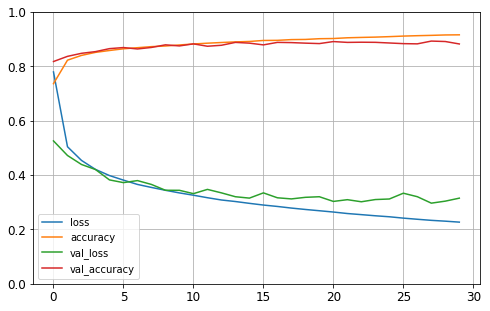

In [70]:
pd.DataFrame(history4.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
# save_fig("keras_learning_curves_plot")
plt.show()

In [71]:
model4.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 31us/sample - loss: 0.3528 - accuracy: 0.8758


[0.3528335156917572, 0.8758]

***Is the MLP Classification produced here better than the Random Forest Classifier produced in Programming Assignment 2? The answer is yes! The multiple models produced here, after tweaking with the number of hidden layers and the amount of neurons, all seem to outperform it by about 2-3%, where the Random Forest Classifier performed at about 85% previously***

### Model Performances
For the last part, we will model the final model using the highest performing model here at 87.94% accuracy in Model 4.

| Model Trial  # | Model Performance Accuracy  |
|      :---:     |            :---:            |
| 1              | 87.92%                      |
| 2              | 87.87%                      |
| 3              | 87.65%                      |
| 4              | 87.94%                      |

### 2. Using PCA to reduce dimensionality, then train a classifier, record training time, compare training times, compare classification results

In [72]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 0.95)
X_train_redu = pca.fit_transform(X_train)
X_test_redu = pca.transform(X_test)
X_val_redu = pca.transform(X_val)

In [73]:
X_train_redu.shape

(55000, 188)

We must reduce the other 2 sets in such a way that is usable based off the dimensionality of the reduced training set, or else the trained model is not applicable given the difference in dimensions. We reduce ```X_train``` to be 95% of its explained variance, but reduce ```X_test``` and ```X_val``` according to the dimensions "188" of the result from the former.

In [74]:
X_test_redu.shape

(10000, 188)

In [75]:
X_val_redu.shape

(5000, 188)

It would be interesting to see how the MLP Classifier from sklearn would perform given the dimensionality reduced set and original set, then compare 

In [76]:
from sklearn.neural_network import MLPClassifier

MLP_CLF = MLPClassifier(random_state=42)

In [77]:
import time

In [78]:
start1 = time.time()
MLP_CLF.fit(X_train_redu, y_train)
stop1 = time.time()

redu_train_time = stop1 - start1
print(f"Training time: {redu_train_time}s")

Training time: 86.49812316894531s


C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [79]:
MLP_CLF.score(X_test_redu, y_test)

0.8726

In [80]:
MLP_CLF.score(X_train_redu, y_train)

0.9999636363636364

Now training the same classifier but using the original, non-reduced set

In [81]:
MLP_CLF2 = MLPClassifier(random_state=42)

In [82]:
start2 = time.time()
MLP_CLF2.fit(X_train, y_train)
stop2 = time.time()

norm_train_time = stop2 - start2
print(f"Training time: {norm_train_time}s")

Training time: 136.88723397254944s


In [83]:
MLP_CLF2.score(X_test, y_test)

0.8782

***We can observe that the training time of the dimensionality reduced set seems to be much faster at 86.50 seconds versus training the same classifier on the original ```X_train ``` set which takes 136.89 seconds, which is about 1.58x faster. The accuracy score for using the reduced training set performs at 87.26%. This may be due to the fact that we train the model on the reduced training set, then seeing the accuracy on a reduced test set that was shaped to match the dimensionality of the training set. Meanwhile, the model trained on the non-reduced set performs at about 87.9% accuracy on the test set. It seems that there the trade-off beween model performance and model training speed here is quite large, in that the loss of performance seems to "worth it" in terms of how fast we are able to yield a relatively high performing model*** 

### 3. Improve the neural network from text through RandomizedSearchCV with post PCA data set. Compare results with previous

Using the best performing model from Part 1, we will import that model here

In [84]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [101]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[188]):
    model = keras.models.Sequential()
#     model.add(keras.layers.InputLayer(input_shape=input_shape))
#     for layer in range(n_hidden):
#         model.add(keras.layers.Dense(n_neurons, activation="relu"))
#     model.add(keras.layers.Dense(10))

    model.add(keras.layers.Flatten(input_shape=[188]))
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.Dense(300, activation="relu"))
    model.add(keras.layers.Dense(100, activation="relu"))
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer, metrics=["accuracy"])
    
    return model

In [102]:
keras_clf = keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [103]:
keras_clf.fit(X_train_redu, y_train, epochs=100, 
              validation_data=(X_val_redu, y_val),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 3s 58us/sample - loss: 1.1547 - accuracy: 0.6494 - val_loss: 0.6861 - val_accuracy: 0.7558
Epoch 2/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.6261 - accuracy: 0.7735 - val_loss: 0.5512 - val_accuracy: 0.8014
Epoch 3/100
55000/55000 [==============================] - 3s 48us/sample - loss: 0.5345 - accuracy: 0.8065 - val_loss: 0.4930 - val_accuracy: 0.8262
Epoch 4/100
55000/55000 [==============================] - 3s 48us/sample - loss: 0.4867 - accuracy: 0.8236 - val_loss: 0.4614 - val_accuracy: 0.8352
Epoch 5/100
55000/55000 [==============================] - 3s 48us/sample - loss: 0.4569 - accuracy: 0.8355 - val_loss: 0.4392 - val_accuracy: 0.8448
Epoch 6/100
55000/55000 [==============================] - 3s 48us/sample - loss: 0.4363 - accuracy: 0.8419 - val_loss: 0.4230 - val_accuracy: 0.8492
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.2494 - accuracy: 0.9095 - val_loss: 0.3067 - val_accuracy: 0.8902
Epoch 56/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.2479 - accuracy: 0.9111 - val_loss: 0.3044 - val_accuracy: 0.8928
Epoch 57/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.2457 - accuracy: 0.9110 - val_loss: 0.3040 - val_accuracy: 0.8926
Epoch 58/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.2444 - accuracy: 0.9125 - val_loss: 0.3065 - val_accuracy: 0.8914
Epoch 59/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.2432 - accuracy: 0.9122 - val_loss: 0.3043 - val_accuracy: 0.8946
Epoch 60/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.2412 - accuracy: 0.9125 - val_loss: 0.3047 - val_accuracy: 0.8928
Epoch 61/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.2395 - ac

In [91]:
# # Not used later, get an idea of score, but loss is changed to sparse categorical crossentropy

# mse_test = keras_clf.score(X_test_redu, y_test)

In [92]:
# # y_pred is not used hereafter, obsolete 

# X_new = X_test_redu[:3]
# y_pred = keras_clf.predict(X_new)

In [104]:
np.random.seed(42)
tf.random.set_seed(42)

In [105]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_clf, param_distribs, 
                                   n_iter=10, cv=3, verbose=3, 
                                   n_jobs=-1)

rnd_search_cv.fit(X_train_redu, y_train, epochs=100, 
                  validation_data=(X_val_redu, y_val),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  30 | elapsed:  2.6min remaining: 12.9min
[Parallel(n_jobs=-1)]: Done  16 out of  30 | elapsed:  4.9min remaining:  4.2min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  6.0min remaining:   39.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  6.3min finished


Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 3s 55us/sample - loss: 1.0043 - accuracy: 0.6781 - val_loss: 0.6127 - val_accuracy: 0.7828
Epoch 2/100
55000/55000 [==============================] - 3s 48us/sample - loss: 0.5552 - accuracy: 0.7989 - val_loss: 0.4945 - val_accuracy: 0.8268
Epoch 3/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.4740 - accuracy: 0.8297 - val_loss: 0.4501 - val_accuracy: 0.8440
Epoch 4/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.4352 - accuracy: 0.8438 - val_loss: 0.4235 - val_accuracy: 0.8542
Epoch 5/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.4111 - accuracy: 0.8531 - val_loss: 0.4067 - val_accuracy: 0.8562
Epoch 6/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.3941 - accuracy: 0.8597 - val_loss: 0.3934 - val_accuracy: 0.8640
Epoch 7/100
55000/55000 [==========================

Epoch 55/100
55000/55000 [==============================] - 3s 48us/sample - loss: 0.2022 - accuracy: 0.9266 - val_loss: 0.2979 - val_accuracy: 0.8936
Epoch 56/100
55000/55000 [==============================] - 3s 46us/sample - loss: 0.2000 - accuracy: 0.9271 - val_loss: 0.2949 - val_accuracy: 0.8932
Epoch 57/100
55000/55000 [==============================] - 3s 46us/sample - loss: 0.1976 - accuracy: 0.9281 - val_loss: 0.2954 - val_accuracy: 0.8962
Epoch 58/100
55000/55000 [==============================] - 3s 47us/sample - loss: 0.1957 - accuracy: 0.9290 - val_loss: 0.2990 - val_accuracy: 0.8944


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000199B359DB70>,
                   iid='warn', n_iter=10, n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000199AFDAAA90>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,...
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_sco

In [106]:
rnd_search_cv.best_params_

{'learning_rate': 0.005153286333701512, 'n_hidden': 1, 'n_neurons': 22}

In [107]:
rnd_search_cv.best_score_

0.8885818062088706

In [108]:
rnd_search_cv.best_estimator_

In [109]:
rnd_search_cv.score(X_test_redu, y_test)

10000/10000 [==============================] - 0s 37us/sample - loss: 0.3361 - accuracy: 0.8833


0.8833

In [110]:
final_model = rnd_search_cv.best_estimator_.model
final_model

In [111]:
final_model.evaluate(X_test_redu, y_test)

10000/10000 [==============================] - 0s 26us/sample - loss: 0.3361 - accuracy: 0.8833


[0.3360758774757385, 0.8833]

In [112]:
final_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 188)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 100)               18900     
_________________________________________________________________
dense_13 (Dense)             (None, 300)               30300     
_________________________________________________________________
dense_14 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_15 (Dense)             (None, 10)                1010      
Total params: 80,310
Trainable params: 80,310
Non-trainable params: 0
_________________________________________________________________


In [114]:
final_model.layers

***It appears that our final performance after packaging the custom MLP Model in Keras into a usable classifier for randomized hyparparameter search in sklearn. We produce a final model that performs at 88.33% over the test set. Another 1.33% higher than the non-tuned, non-optimized models from earlier.***